In [0]:
!nvidia-smi

Sat Feb 29 09:10:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 实现一维卷积神经网络

## 准备IMDB数据集

In [0]:
from keras.datasets import imdb
from keras.preprocessing import sequence

In [0]:
max_features = 10000
max_len = 500

In [0]:
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
25000 train sequences
25000 test sequences


In [0]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


# 训练

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [0]:
model = Sequential()
model.add(layers.Embedding(input_dim=max_features, output_dim=128, input_length=max_len))
model.add(layers.Conv1D(filters=32, kernel_size=7, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=5))
model.add(layers.Conv1D(filters=32, kernel_size=7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())  # 对时间序列的全局最大池化
model.add(layers.Dense(units=1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
____________________________________________

In [0]:
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])


In [0]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 92us/step - loss: 1.6796 - acc: 0.5032 - val_loss: 0.6888 - val_acc: 0.5414
Epoch 2/10
20000/20000 [==============================] - 1s 74us/step - loss: 0.6738 - acc: 0.6365 - val_loss: 0.6654 - val_acc: 0.6612
Epoch 3/10
20000/20000 [==============================] - 1s 74us/step - loss: 0.6295 - acc: 0.7516 - val_loss: 0.6139 - val_acc: 0.7310
Epoch 4/10
20000/20000 [==============================] - 1s 74us/step - loss: 0.5402 - acc: 0.8059 - val_loss: 0.5003 - val_acc: 0.7982
Epoch 5/10
20000/20000 [==============================] - 2s 76us/step - loss: 0.4191 - acc: 0.8452 - val_loss: 0.4176 - val_acc: 0.8328
Epoch 6/10
20000/20000 [==============================] - 1s 72us/step - loss: 0.3553 - acc: 0.8649 - val_loss: 0.4040 - val_acc: 0.8378
Epoch 7/10
20000/20000 [==============================] - 1s 74us/step - loss: 0.3127 - acc: 0.8623 - val_loss: 0.4021 - val_acc:

## 绘制结果

In [0]:
from matplotlib import pyplot as plt

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [0]:
epochs = range(1, len(acc) + 1)

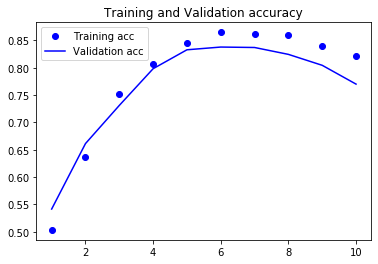

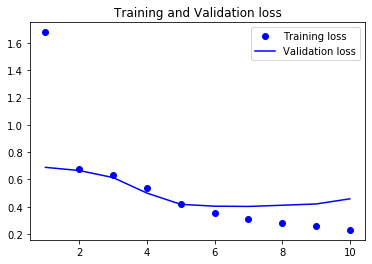

In [0]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

# 在jena数据上训练并评估一个简单的一维卷积神经网络

In [0]:
import os

In [0]:
data_dir = './drive/My Drive/Data/jena'

In [0]:
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [6]:
f = open(fname)
data = f.read()
f.close

<function TextIOWrapper.close>

In [0]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]  # 排除表头

In [0]:
import numpy as np

In [0]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [0]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [0]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [0]:
train_gen = generator(data=float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(data=float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step, batch_size=batch_size)
test_gen = generator(data=float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step, batch_size=batch_size)
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [0]:
model = Sequential()
model.add(layers.Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(pool_size=3))
model.add(layers.Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=3))
model.add(layers.Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(units=1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [0]:
model.compile(optimizer=RMSprop(), loss='mae')

In [0]:
history = model.fit_generator(generator=train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 13s 27ms/step - loss: 0.4176 - val_loss: 0.4619
Epoch 2/20
500/500 [==============================] - 13s 26ms/step - loss: 0.3600 - val_loss: 0.4583
Epoch 3/20
500/500 [==============================] - 13s 26ms/step - loss: 0.3335 - val_loss: 0.4432
Epoch 4/20
500/500 [==============================] - 13s 26ms/step - loss: 0.3163 - val_loss: 0.4616
Epoch 5/20
500/500 [==============================] - 14s 27ms/step - loss: 0.3031 - val_loss: 0.4492
Epoch 6/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2948 - val_loss: 0.4554
Epoch 7/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2881 - val_loss: 0.4507
Epoch 8/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2798 - val_loss: 0.4621
Epoch 9/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2756 - val_loss: 0.4602
Epoch 10/20
500/500 [==============================] - 13s 25ms/step - loss: 0.268

## 绘制结果

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

In [0]:
epochs = range(1, len(loss) + 1)

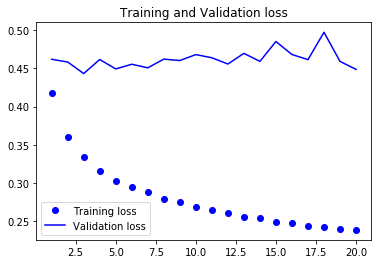

In [0]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

## 准备更高分辨率的数据生成器

In [0]:
step = 3
lookback = 720
delay = 144

In [0]:
train_gen = generator(data=float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step)

In [0]:
val_gen = generator(data=float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step)

In [0]:
test_gen = generator(data=float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step)

In [0]:
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

# 结合一维卷积层和GRU层的模型

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [13]:
model = Sequential()
model.add(layers.Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(pool_size=3))
model.add(layers.Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(layers.GRU(units=32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(units=1))
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_______________________________________________________________

In [14]:
model.compile(optimizer=RMSprop(), loss='mse')

In [21]:
history = model.fit_generator(generator=train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





500/500 [==============================] - 80s 161ms/step - loss: 0.1814 - val_loss: 0.1284
Epoch 2/20
500/500 [==============================] - 65s 129ms/step - loss: 0.1500 - val_loss: 0.1230
Epoch 3/20
500/500 [==============================] - 65s 131ms/step - loss: 0.1380 - val_loss: 0.1190
Epoch 4/20
500/500 [==============================] - 67s 134ms/step - loss: 0.1303 - val_loss: 0.1193
Epoch 5/20
500/500 [==============================] - 70s 140ms/step - loss: 0.1227 - val_loss: 0.1213
Epoch 6/20
500/500 [==============================] - 70s 140ms/step - loss: 0.1184 - val_loss: 0.1275
Epoch 7/20
500/500 [==============================] - 68s 137ms/step - loss: 0.1124 - val_loss: 0.1265
Epoch 8/20
500/500 [==============================] - 66s 132ms/step - loss: 0.1082 - val_loss: 0.1338
Epoch 9/20
500/500 [==============================] - 66s 132ms/step - los

### 绘制结果

In [0]:
from matplotlib import pyplot as plt

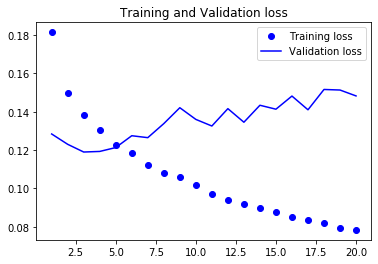

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [0]:
# 效果不如只用正则化GRU，但是训练速度要快得多